In [5]:
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta, time
import gzip
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tabulate import tabulate
from pandas import json_normalize

In [6]:
# LOCAL = 'Avenches'
LOCAL = 'Lausanne'
group_to_type = {
    0: 'home',
    1: 'education',
    2: 'work',
    3: 'leisure',
    4: 'shop'
}
HORIZON = 289

In [51]:
# activity_csv = pd.read_csv("./data_preprocessed/activity.csv")
# population_csv = pd.read_csv("./data_preprocessed/population.csv")
activity_csv = pd.read_csv("./data_preprocessed/TEST_activity.csv")
population_csv = pd.read_csv("./data_preprocessed/TEST_population.csv")
NUM_ACTIVITIES = len(activity_csv) + 3   

In [7]:
# Specify the file paths
activity_file = 'data_original/vaud_activities.csv.gz'
population_file = 'data_original/vaud_population.csv.gz'
trip_file = 'data_original/vaud_trips.csv.gz'

# Read the gzipped CSV files
def read_gzipped_csv(file_path):
    with gzip.open(file_path, 'rt') as file:
        df = pd.read_csv(file)
    return df

# Read the dataframes
activity_vaud = read_gzipped_csv(activity_file)
population_vaud = read_gzipped_csv(population_file)[['id', 'age', 'home_x', 'home_y', 'local']].drop_duplicates()
trip_vaud = read_gzipped_csv(trip_file)[['Unnamed: 0', 'id', 'mode', 'dep_time','trav_time','start_link','end_link']].drop_duplicates()

#### Generic functions :

In [8]:
# https://matplotlib.org/stable/gallery/color/named_colors.html 
color_palette = {
    'home': 'royalblue',       
    'work': 'gold',     
    'leisure': 'lightpink', # RGB tuple, each value must be in the range [0, 1]
    'shop': 'aquamarine', 
    'transport': 'silver',   
    'pt interaction': 'grey',
    'other': 'mediumvioletred',
    'education': 'teal',
}

In [9]:
def plot_schedule_dataset(activity_df, individual_id):
    individual_schedule = activity_df[activity_df['id'] == individual_id]
    individual_schedule = individual_schedule.sort_index()
    
    segments = []
    colors = []
    fig, ax = plt.subplots(figsize=(10, 1))
    
    start_of_day = datetime.strptime('00:00:00', '%H:%M:%S')
    end_of_day = datetime.strptime('23:59:59', '%H:%M:%S')
    prev_end = start_of_day
    
    for _, facility in individual_schedule.iterrows():
        start_time = datetime.strptime(facility['start_time'], '%H:%M:%S') if pd.notna(facility['start_time']) else start_of_day
        end_time = datetime.strptime(facility['end_time'], '%H:%M:%S') if pd.notna(facility['end_time']) else end_of_day
        
        if prev_end < start_time:
            segments.append([(prev_end - start_of_day).total_seconds() / 3600, (start_time - prev_end).total_seconds() / 3600])
            colors.append(color_palette['transport'])
            ax.broken_barh([segments[-1]], (0, 1), facecolors=colors[-1])
            
        segments.append([(start_time - start_of_day).total_seconds() / 3600, (end_time - start_time).total_seconds() / 3600])
        colors.append(color_palette[facility['type']])
        ax.broken_barh([segments[-1]], (0, 1), facecolors=colors[-1])
        
        prev_end = end_time


    legend_patches = [mpatches.Patch(color=color, label=activity) for activity, color in color_palette.items()]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax.set_xlim(0, 24)
    ax.set_yticks([])
    ax.set_xticks(range(25))
    ax.set_xlabel('Original schedule')
    plt.show()

In [10]:
def print_schedule(activity_df, individual_id):
    individual_schedule = activity_df[activity_df['id'] == individual_id]
    individual_schedule = individual_schedule.sort_index()
    print(tabulate(individual_schedule, headers='keys', tablefmt='pipe'))

In [11]:
def horizons_to_timedelta(n):
    minutes = n * 5
    time_delta = timedelta(minutes=minutes)
    return time_delta

In [12]:
def json_to_flat_dataframe(json_path):
    with open(json_path, 'r') as file:
        data = pd.read_json(file)
    
    # Normalize the 'daily_schedule' data to create a flat table
    # We will concatenate all the schedules along with their top-level data such as 'id', 'execution_time', etc.
    flat_data = pd.DataFrame()  # Empty dataframe to hold our flattened data
    for record in data.to_dict(orient='records'):
        # Normalize the daily_schedule for each record
        schedule_df = json_normalize(record, 'daily_schedule', errors='ignore')
        
        # Adding the top-level data as new columns to the schedule_df
        for col in data.columns.difference(['daily_schedule']):
            schedule_df[col] = record[col]
        
        # Append to the flat_data DataFrame
        flat_data = pd.concat([flat_data, schedule_df], ignore_index=True)
    
    return flat_data

In [13]:
def minutes_to_time2(minute_value):
    total_minutes = minute_value * 5
    hours, minutes = divmod(total_minutes, 60)
    if hours >= 24:
        hours = hours % 24
    return time(hour=int(hours), minute=int(minutes))

In [91]:
# Helper function to convert a time object to minutes
def time_to_minutes(t):
    return t.hour * 60 + t.minute

# Helper function to convert minutes to a time object
def minutes_to_time(minutes):
    hours, minutes = divmod(minutes, 60)
    return time(hour=hours, minute=minutes)

# Function to calculate the end time of activities
def calculate_end_time(row):

    start_minutes = time_to_minutes(row['start'])
    duration_minutes = time_to_minutes(row['duration'])
    end_minutes = start_minutes + duration_minutes

    # Handle the special case for the last row
    if end_minutes >= 1440:
        return time(23, 59, 0)

    return minutes_to_time(end_minutes)

In [116]:
def plot_schedule_json(df, individual_id):
    individual_schedule = df[df['id'] == individual_id].sort_values(by='start')
    
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.set_xlim(0, 24)
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.set_xticks(range(0, 25, 1))
    ax.set_xlabel(f"Predicted schedule (U={individual_schedule.iloc[0]['utility']:.1f})")
    
    # Convert time objects to hours since the start of the day
    time_to_hours = lambda t: t.hour + t.minute / 60 + t.second / 3600
    
    prev_end_time = time_to_hours(datetime.strptime('00:00:00', '%H:%M:%S').time())
    
    # Iterate over the activities
    for _, activity in individual_schedule.iterrows():
        start_time = time_to_hours(activity['start'])
        end_time = time_to_hours(activity['end_time'])
        
        # If there is a gap between the previous end time and the current start time, plot it as 'transport'
        if prev_end_time < start_time:
            ax.broken_barh([(prev_end_time, start_time - prev_end_time)], (0, 1), facecolors=color_palette['transport'])
        
        ax.broken_barh([(start_time, end_time - start_time)], (0, 1), facecolors=color_palette[activity['group']])
        
        prev_end_time = end_time

    legend_patches = [mpatches.Patch(color=color, label=activity) for activity, color in color_palette.items()]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [93]:
def filter_and_sort_activities(df):
    # Convert 'start' and 'duration' from time objects to timedeltas for comparison
    df['duration_td'] = df['duration'].apply(lambda x: pd.to_timedelta(x.strftime('%H:%M:%S')))
    
    # Group by 'acity' and find the index of the row with the maximum duration
    idx = df.groupby(['acity', 'id', 'start'])['duration_td'].idxmax()
    
    # Select only the rows with the maximum duration
    max_duration_df = df.loc[idx]
    
    # Drop the auxiliary 'duration_td' column
    max_duration_df = max_duration_df.drop(columns=['duration_td'])
    
    # Now, sort the resulting DataFrame by the 'start' column
    max_duration_df = max_duration_df.sort_values(by='start', ascending = True)
    
    return max_duration_df

In [94]:
def reorder_df(df):
    new_order = [
        'acity', 'facility', 'group', 'start', 'duration', 'end_time', 'time',
        'cum_utility', 'DSSR_iterations', 'execution_time', 'id', 'utility'
    ]
    df = df[new_order]
    return df

In [95]:
def compare_individual_schedules(df_dataset, df_json, individual_id, table=True, plot=True):
    if table: 
        print("Here is his/her schedule in the original dataset :\n")
        print_schedule(df_dataset, individual_id)
    if plot:
        plot_schedule_dataset(df_dataset, individual_id)
    if table:
        print("Here is his/her schedule with our planning algorythm :\n")
        print_schedule(df_json, individual_id)
    if plot:
        plot_schedule_json(df_json, individual_id)

#### Tests :

In [118]:
path_to_json_file = "data_output/schedules.json"
df = json_to_flat_dataframe(path_to_json_file)
# print(set(df['id']))
# df.head(30)

In [119]:
df['start'] = df['start'].apply(minutes_to_time2)
df['duration'] = df['duration'].apply(minutes_to_time2)
df['time'] = df['time'].apply(minutes_to_time2)
# print(set(df['id']))
# df.head()

In [120]:
filtered_df = filter_and_sort_activities(df)
# print(set(filtered_df['id']))
# print(len(filtered_df))
# filtered_df.head(20)

In [121]:
filtered_df['end_time'] = filtered_df.apply(calculate_end_time, axis=1)
# filtered_df.head()

In [122]:
schedule_postprocessed = reorder_df(filtered_df)
# schedule_postprocessed.head()

In [126]:
activity_vaud.head(10)

,Unnamed: 0,id,type,facility,link,x,y,start_time,end_time
0,423464,1069770,home,home480932,399007,2569239.0,1190194.0,NaN,09:23:32
1,423465,1069770,shop,168569,244909,2571696.0,1189601.0,09:25:32,09:33:32
2,423466,1069770,home,home480932,399007,2569239.0,1190194.0,09:35:32,09:53:32
3,423467,1069770,leisure,399230,399013,2569430.0,1189314.0,09:56:32,10:23:32
4,423468,1069770,home,home480932,399007,2569239.0,1190194.0,10:26:32,NaN
5,434919,1071953,home,home483115,136934,2551461.0,1166062.0,NaN,15:24:50
6,434920,1071953,shop,556083,28368,2538494.0,1159675.0,15:44:50,16:24:50
7,434921,1071953,home,home483115,136934,2551461.0,1166062.0,16:39:50,NaN
8,587539,1098681,home,home509843,434643,2565711.0,1194908.0,NaN,08:51:27
9,587540,1098681,shop,432303,903993,2564562.0,1195868.0,08:53:27,09:01:27



 SCHEDULE OF INDIVIDUAL 6434785 (n*0) 



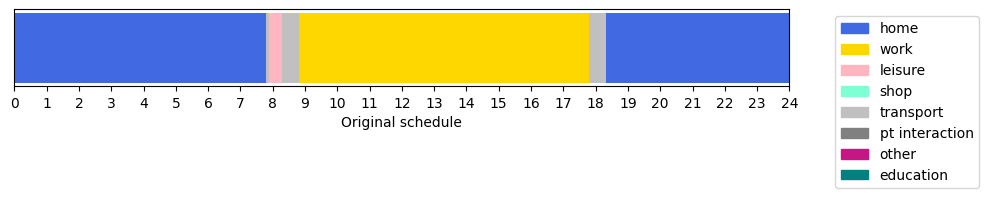

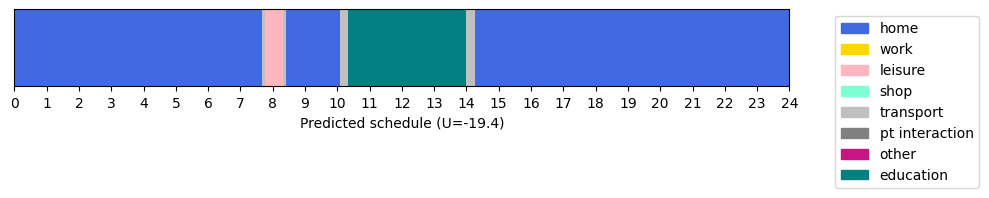


 SCHEDULE OF INDIVIDUAL 6955784 (n*1) 



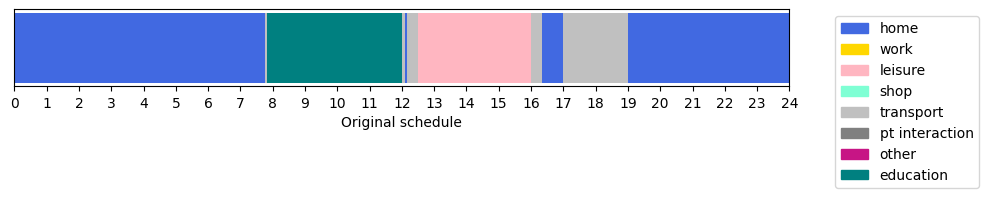

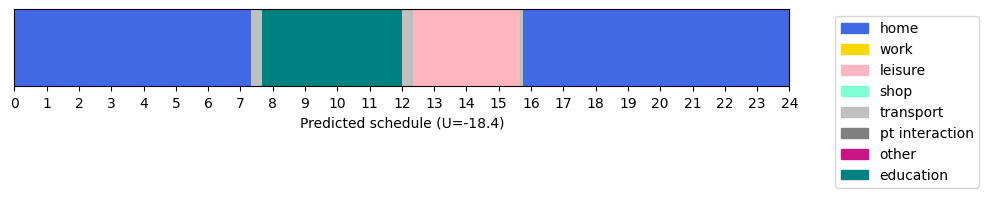


 SCHEDULE OF INDIVIDUAL 6725481 (n*2) 



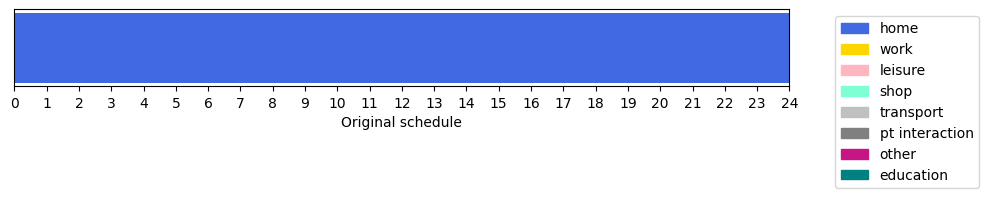

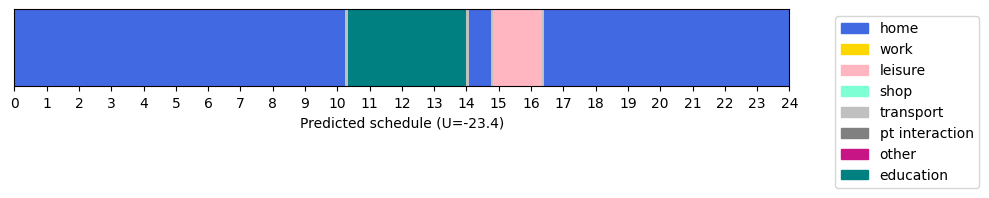


 SCHEDULE OF INDIVIDUAL 6481225 (n*3) 



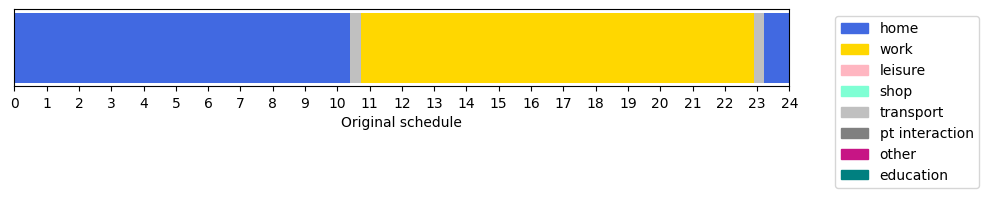

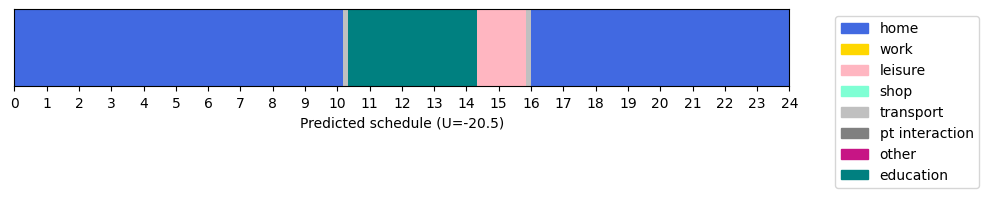


 SCHEDULE OF INDIVIDUAL 7019567 (n*4) 



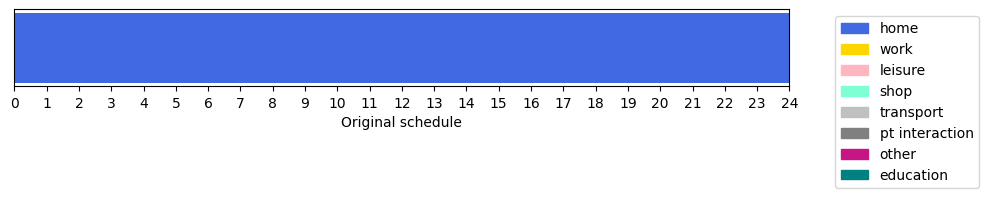

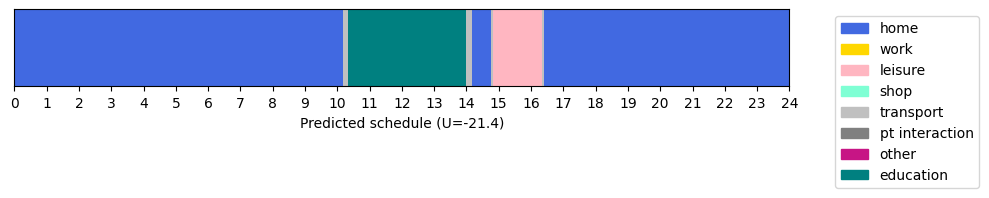


 SCHEDULE OF INDIVIDUAL 6641041 (n*5) 



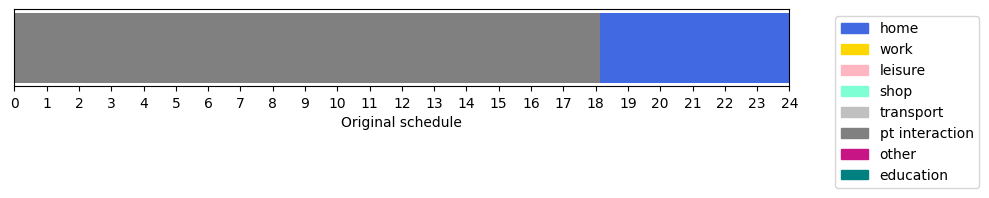

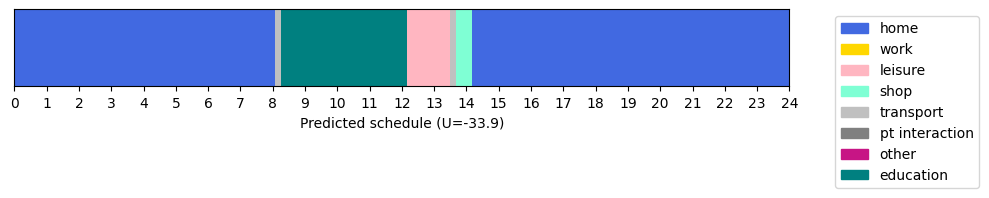


 SCHEDULE OF INDIVIDUAL 6492562 (n*6) 



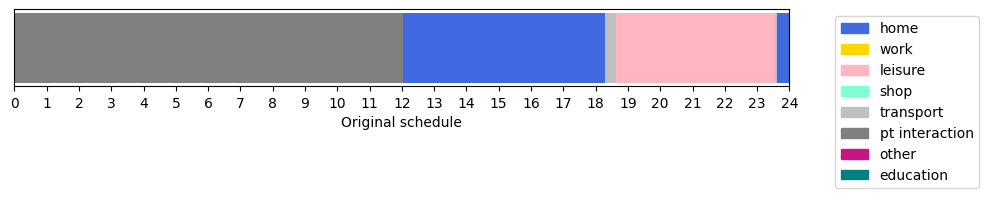

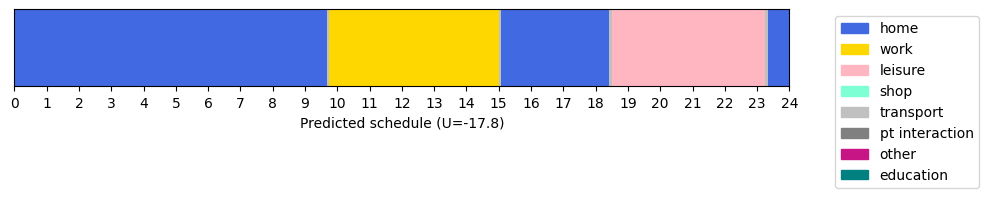


 SCHEDULE OF INDIVIDUAL 6340915 (n*7) 



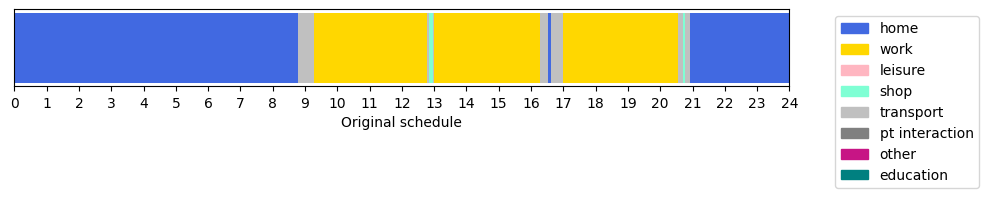

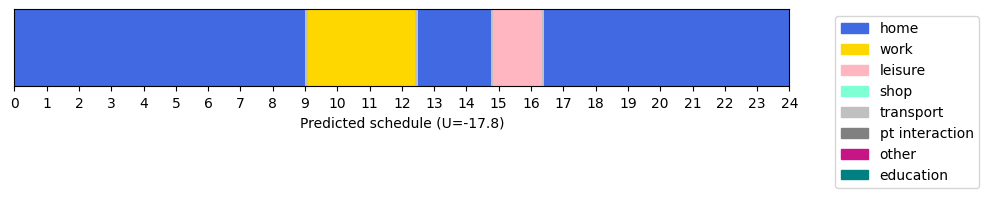


 SCHEDULE OF INDIVIDUAL 7003094 (n*8) 



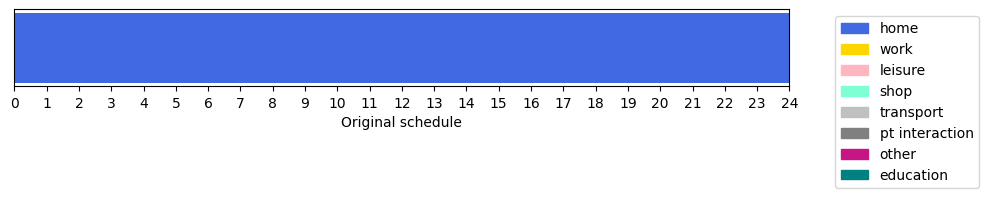

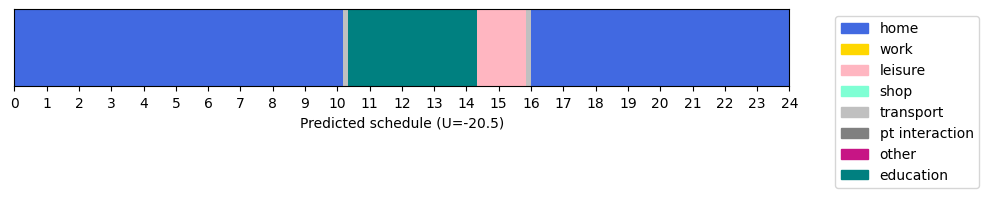


 SCHEDULE OF INDIVIDUAL 6349208 (n*9) 



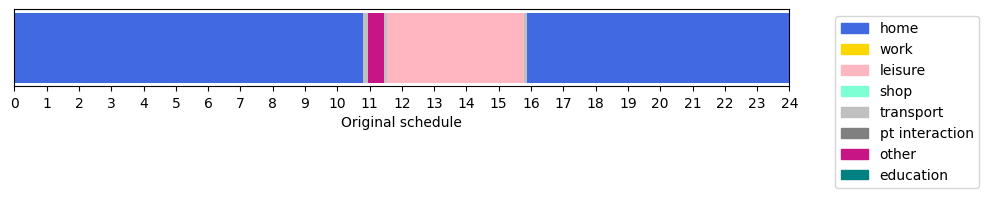

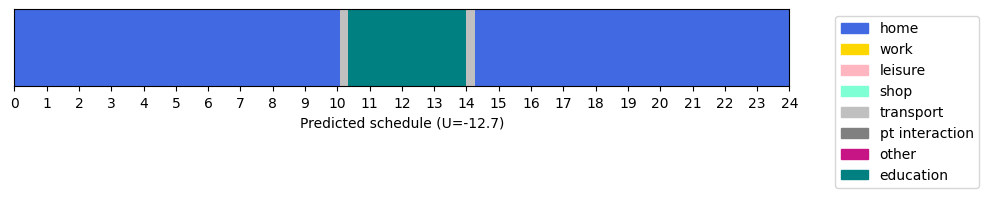


 SCHEDULE OF INDIVIDUAL 7120345 (n*10) 



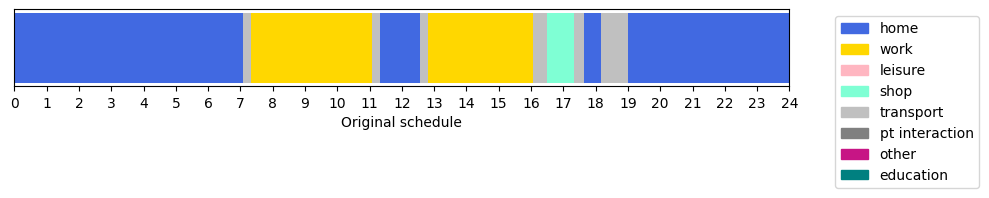

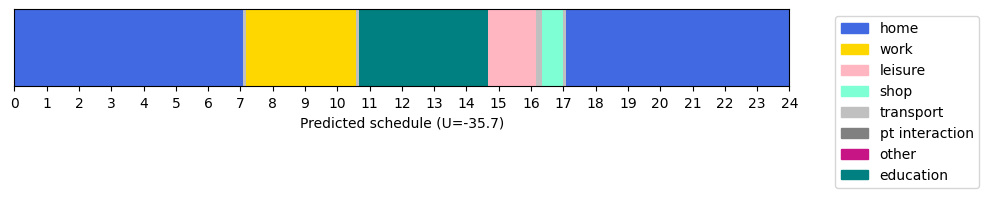


 SCHEDULE OF INDIVIDUAL 6337051 (n*11) 



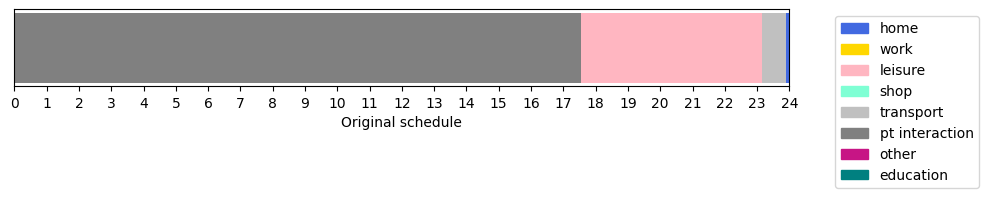

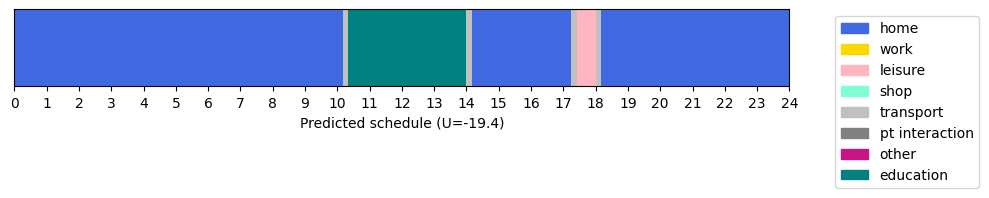

In [123]:
for index, id in enumerate(set(schedule_postprocessed['id'])):
    print(f"\n SCHEDULE OF INDIVIDUAL {id} (n*{index}) \n")
    compare_individual_schedules(activity_vaud, schedule_postprocessed, id, table=False, plot=True)
    if index > 10:
        break

Here is his/her schedule in the original dataset :

|        |   Unnamed: 0 |      id | type           | facility    | link       |           x |           y | start_time   | end_time   |
|-------:|-------------:|--------:|:---------------|:------------|:-----------|------------:|------------:|:-------------|:-----------|
| 179730 |     31914168 | 6337051 | home           | home2791660 | 945033     | 2.53934e+06 | 1.15286e+06 | nan          | 15:13:41   |
| 179731 |     31914169 | 6337051 | other          | 172373      | 139241     | 2.53861e+06 | 1.15297e+06 | 15:13:41     | 15:43:41   |
| 179732 |     31914170 | 6337051 | pt interaction | nan         | 368718     | 2.53857e+06 | 1.15215e+06 | nan          | nan        |
| 179733 |     31914171 | 6337051 | pt interaction | nan         | 410761     | 2.54015e+06 | 1.1513e+06  | nan          | nan        |
| 179734 |     31914172 | 6337051 | pt interaction | nan         | 934385     | 2.5402e+06  | 1.15137e+06 | nan          | nan      

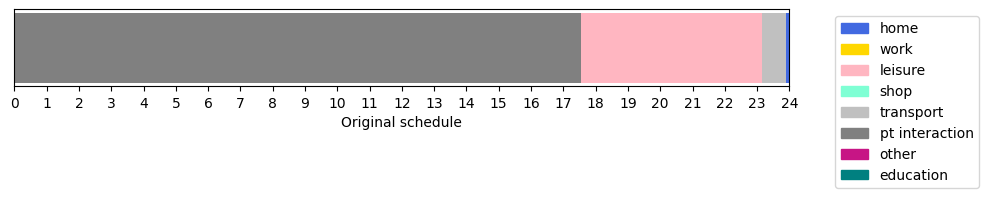

Here is his/her schedule with our planning algorythm :

|      |   acity |   facility | group     | start    | duration   | end_time   | time     |   cum_utility |   DSSR_iterations |   execution_time |      id |   utility |
|-----:|--------:|-----------:|:----------|:---------|:-----------|:-----------|:---------|--------------:|------------------:|-----------------:|--------:|----------:|
| 1053 |       0 |          0 | home      | 00:00:00 | 00:05:00   | 00:05:00   | 00:05:00 |          0    |                 0 |            0.017 | 6337051 |    -19.44 |
| 1171 |      23 |          0 | home      | 00:05:00 | 10:05:00   | 10:10:00   | 10:10:00 |          0    |                 0 |            0.017 | 6337051 |    -19.44 |
| 1210 |       1 |     381489 | education | 10:20:00 | 03:40:00   | 14:00:00   | 14:00:00 |        -16.7  |                 0 |            0.017 | 6337051 |    -19.44 |
| 1244 |      23 |          0 | home      | 14:10:00 | 03:05:00   | 17:15:00   | 17:15:00 |        

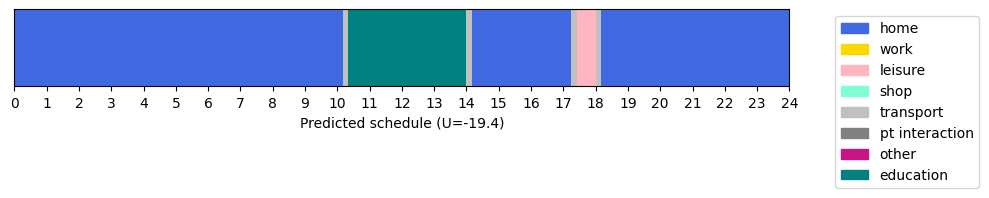

In [124]:
# 7019567
# 6641041 
# 6492562 
# 6337051 
compare_individual_schedules(activity_vaud, schedule_postprocessed, 6337051, table=True, plot=True)

In [145]:
# df = activity_vaud
df = activity_vaud[activity_vaud['type'].isin(['shop', 'leisure', 'work', 'education'])] # + filtre sur lausanne !
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce').fillna(pd.Timestamp('00:00:00'))
df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce').fillna(pd.Timestamp('23:59:00'))
df.head()

C:\Users\helli\AppData\Local\Temp\ipykernel_4580\3792218228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce').fillna(pd.Timestamp('00:00:00'))
C:\Users\helli\AppData\Local\Temp\ipykernel_4580\3792218228.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce').fillna(pd.Timestamp('23:59:00'))


,Unnamed: 0,id,type,facility,link,x,y,start_time,end_time,hours
1,423465,1069770,shop,168569,244909,2571696.0,1189601.0,2023-11-07 09:25:32,2023-11-07 09:33:32,[9]
3,423467,1069770,leisure,399230,399013,2569430.0,1189314.0,2023-11-07 09:56:32,2023-11-07 10:23:32,"[9, 10]"
6,434920,1071953,shop,556083,28368,2538494.0,1159675.0,2023-11-07 15:44:50,2023-11-07 16:24:50,"[15, 16]"
9,587540,1098681,shop,432303,903993,2564562.0,1195868.0,2023-11-07 08:53:27,2023-11-07 09:01:27,"[8, 9]"
11,587542,1098681,leisure,660043,433882,2565818.0,1194918.0,2023-11-07 09:24:27,2023-11-07 09:51:27,[9]


In [146]:
# Function to create list of hours covered by the activity
def get_hours_list(row):
    start_hour = row['start_time'].hour
    end_hour = row['end_time'].hour + (1 if row['end_time'].minute > 0 else 0)  # adjust if minutes > 0
    return list(range(start_hour, end_hour))

# Apply the function and create a new 'hours' column
df['hours'] = df.apply(get_hours_list, axis=1)
df.head()

C:\Users\helli\AppData\Local\Temp\ipykernel_4580\1343186947.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hours'] = df.apply(get_hours_list, axis=1)


,Unnamed: 0,id,type,facility,link,x,y,start_time,end_time,hours
1,423465,1069770,shop,168569,244909,2571696.0,1189601.0,2023-11-07 09:25:32,2023-11-07 09:33:32,[9]
3,423467,1069770,leisure,399230,399013,2569430.0,1189314.0,2023-11-07 09:56:32,2023-11-07 10:23:32,"[9, 10]"
6,434920,1071953,shop,556083,28368,2538494.0,1159675.0,2023-11-07 15:44:50,2023-11-07 16:24:50,"[15, 16]"
9,587540,1098681,shop,432303,903993,2564562.0,1195868.0,2023-11-07 08:53:27,2023-11-07 09:01:27,"[8, 9]"
11,587542,1098681,leisure,660043,433882,2565818.0,1194918.0,2023-11-07 09:24:27,2023-11-07 09:51:27,[9]


In [147]:
# Explode 'hours' so each hour is a separate row
df_hours_exploded = df.explode('hours')
df_hours_exploded.head()

,Unnamed: 0,id,type,facility,link,x,y,start_time,end_time,hours
1,423465,1069770,shop,168569,244909,2571696.0,1189601.0,2023-11-07 09:25:32,2023-11-07 09:33:32,9
3,423467,1069770,leisure,399230,399013,2569430.0,1189314.0,2023-11-07 09:56:32,2023-11-07 10:23:32,9
3,423467,1069770,leisure,399230,399013,2569430.0,1189314.0,2023-11-07 09:56:32,2023-11-07 10:23:32,10
6,434920,1071953,shop,556083,28368,2538494.0,1159675.0,2023-11-07 15:44:50,2023-11-07 16:24:50,15
6,434920,1071953,shop,556083,28368,2538494.0,1159675.0,2023-11-07 15:44:50,2023-11-07 16:24:50,16


In [148]:
# Count occurrences
hour_activity_count = df_hours_exploded.groupby(['hours', 'type']).size().unstack(fill_value=0)
print(hour_activity_count)

type   education  leisure   shop    work
hours                                   
0              0        0      0      50
1              0        0      0     226
2              0        1      0     504
3              0       70     11    1547
4              0      285      8    5255
5             22      966    296   20658
6           3840     3583   1616   84577
7          46902     8813   5334  180088
8          76380    21227  19856  234378
9          79938    36968  38518  251088
10         80891    45232  46552  255661
11         79788    61889  37919  257248
12         51184    83864  31050  237663
13         61038    82738  29004  236475
14         62911    78241  36765  236082
15         57271    84518  37804  230693
16         33555    87549  38319  214107
17         14604    91770  39525  158696
18          7992   100869  28393   81310
19          6205   108860  11964   39315
20          4654    94848   3606   21820
21          3200    69989    713   13827
22          1350

In [149]:
# Calculate proportions
total_people = df['id'].nunique()
hour_activity_proportion = hour_activity_count.div(total_people)
print(hour_activity_proportion)

type   education   leisure      shop      work
hours                                         
0       0.000000  0.000000  0.000000  0.000084
1       0.000000  0.000000  0.000000  0.000380
2       0.000000  0.000002  0.000000  0.000848
3       0.000000  0.000118  0.000019  0.002604
4       0.000000  0.000480  0.000013  0.008846
5       0.000037  0.001626  0.000498  0.034773
6       0.006464  0.006031  0.002720  0.142366
7       0.078949  0.014835  0.008979  0.303136
8       0.128568  0.035731  0.033423  0.394521
9       0.134557  0.062227  0.064836  0.422648
10      0.136161  0.076138  0.078359  0.430346
11      0.134304  0.104176  0.063828  0.433017
12      0.086156  0.141165  0.052265  0.400050
13      0.102743  0.139270  0.048821  0.398050
14      0.105896  0.131700  0.061885  0.397389
15      0.096402  0.142266  0.063634  0.388318
16      0.056482  0.147368  0.064501  0.360399
17      0.024582  0.154473  0.066531  0.267128
18      0.013453  0.169789  0.047793  0.136866
19      0.010

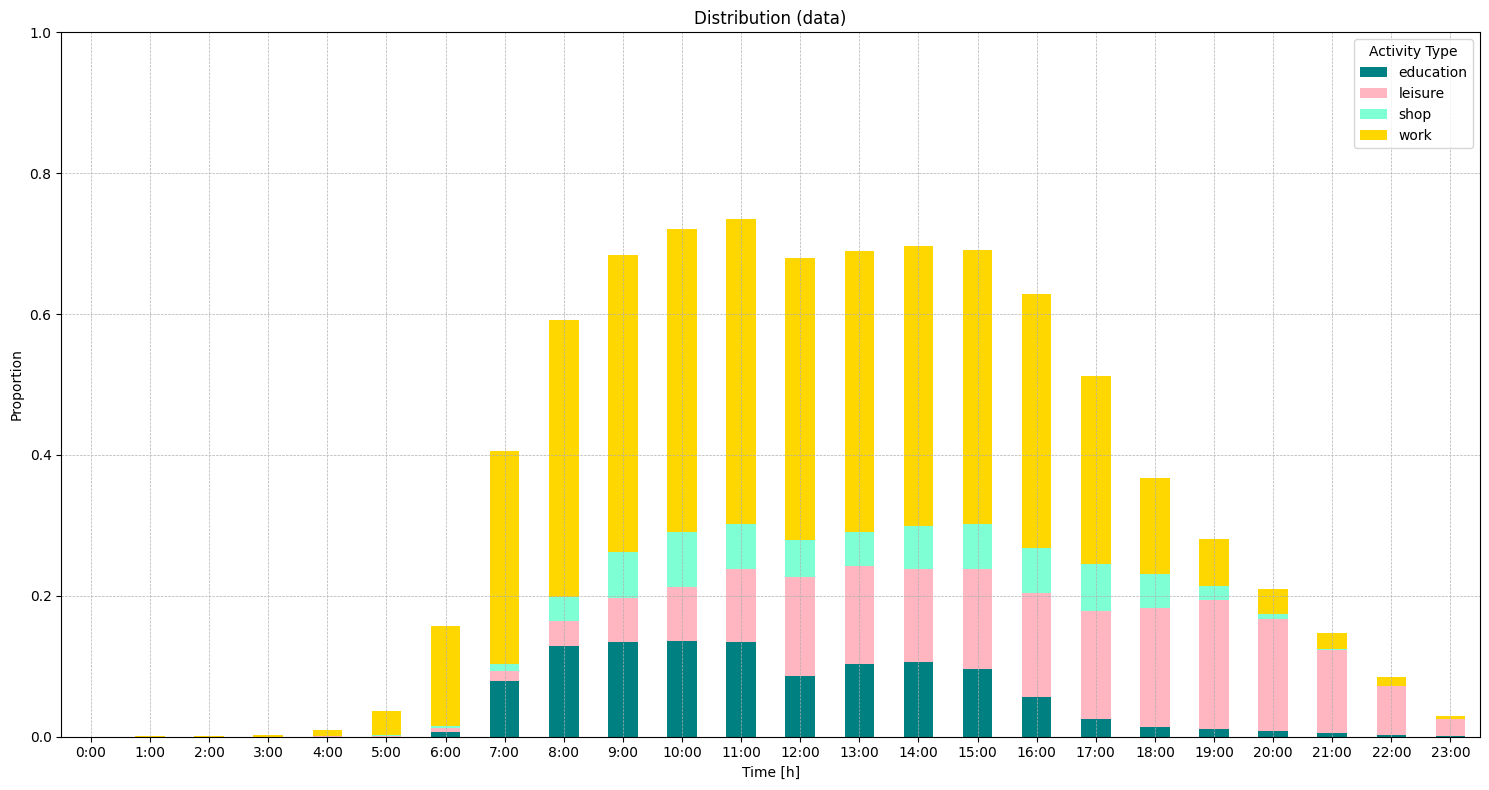

In [151]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

# Create a stacked bar chart
hour_activity_proportion.plot(kind='bar', stacked=True, ax=ax, color=[color_palette[activity] for activity in hour_activity_proportion.columns])

ax.set_title('Distribution (data)')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Proportion')

plt.xticks(ticks=range(24), labels=[f'{hour}:00' for hour in range(24)], rotation=0)
ax.legend(title='Activity Type', loc='upper right', bbox_to_anchor=(1.0, 1.0))
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

In [156]:
def calculate_mean_durations(df):
    # Convert 'start_time' and 'end_time' to datetime objects, handle NaT by backfill or forward fill
    df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce').fillna(pd.Timestamp('00:00:00'))
    df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce').fillna(pd.Timestamp('23:59:00'))
    
    # Ensure 'type' column is filtered for relevant activity types
    activity_types = ['shop', 'leisure', 'work', 'education']
    filtered_df = df[df['type'].isin(activity_types)].copy()
    
    # Calculate duration for each row in minutes
    filtered_df['duration'] = (filtered_df['end_time'] - filtered_df['start_time']).dt.total_seconds() / 60
    
    # Group by 'type' and calculate mean duration
    mean_durations = filtered_df.groupby('type')['duration'].mean().reset_index()
    
    # Convert the mean duration from minutes to '%H:%M' format
    mean_durations['duration'] = mean_durations['duration'].apply(
        lambda x: f"{int(x // 60):02d}:{int(x % 60):02d}"
    )
    
    # Calculate the overall mean duration across all types
    overall_mean = filtered_df['duration'].mean()
    overall_mean_formatted = f"{int(overall_mean // 60):02d}:{int(overall_mean % 60):02d}"
    
    # Append the overall mean to the results DataFrame
    overall_mean_df = pd.DataFrame([{'type': 'Overall', 'duration': overall_mean_formatted}])
    results_df = pd.concat([mean_durations, overall_mean_df], ignore_index=True)
    
    # Rename columns for better readability
    results_df.columns = ['Activity Type', 'Average Duration']
    
    return results_df

mean_duration_table = calculate_mean_durations(df)
print(mean_duration_table)

C:\Users\helli\AppData\Local\Temp\ipykernel_4580\2649309663.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce').fillna(pd.Timestamp('00:00:00'))
C:\Users\helli\AppData\Local\Temp\ipykernel_4580\2649309663.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce').fillna(pd.Timestamp('23:59:00'))


  Activity Type Average Duration
0     education            03:51
1       leisure            01:24
2          shop            00:33
3          work            05:09
4       Overall            02:48


In [157]:
def calculate_activity_proportions(df):
    # Filter the DataFrame for relevant activity types if needed
    activity_types = ['shop', 'leisure', 'work', 'education']
    filtered_df = df[df['type'].isin(activity_types)]
    
    # Group by 'id' and 'type' and check if the activity exists in the schedule
    activity_by_individual = filtered_df.groupby(['id', 'type']).size().unstack(fill_value=0)
    
    # Now check for the presence of each activity, result is boolean
    activity_presence = activity_by_individual > 0

    # Calculate the proportion of individuals that have each activity
    activity_proportions = activity_presence.mean()
    
    # Convert the proportions to a DataFrame for nice formatting
    proportions_df = activity_proportions.reset_index()
    proportions_df.columns = ['Activity Type', 'Proportion']
    
    return proportions_df

activity_proportions_table = calculate_activity_proportions(df)
print(activity_proportions_table)


  Activity Type  Proportion
0     education    0.156394
1       leisure    0.510052
2          shop    0.400880
3          work    0.485848
